### AutoRegressive Properties of Order Book Statistics

The idea is if we provide a set of features X and targets y perhaps we can show that function $y=f(X)$ is invariant to changepoints

In other words the occurrence of a changepoint in X is indicative of a changepoint in y

One way we can do this is individually determine changepoints in both our features and targets and see how close these are -> See if time series model is invariant to changepoints

It would make sense if we didn't solve for autoregressions as this would require the changepoints to occur in very short sequences 

So we want vector regressions between different variables

In [1]:
! pip install ruptures

import ruptures as rpt  # our package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import VAR, ccf
import sys
import os
import logging

from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller


sys.path.append("/home/jovyan/data_warehouse/")
from dw_src.api.features_api import get_features_df, load_features

  Using cached ruptures-1.1.7-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)


In [2]:
df=pd.read_csv('/home/jovyan/personal/Changepoint_LOB/params/hourly_params.csv')
alpha=df['Alpha']
delta=df['Delta']
buys=df['Buy']
sells=df['Sell']
information=df['Mu']
prob=df['prob']

We can solve for an Autoregression model by computing OLS where we regress upon lagged terms and estimate optimal coefficients

We solve for the estimated values along with a two sided confidence interval, can compute p-value signifying if it is noticeable different from zero

In [3]:
adf,p,lag,nobs,cv,icbest=adfuller(prob.dropna())
print("Probability that the Null Hypothesis is true/there is a unit root",p)

Probability that the Null Hypothesis is true/there is a unit root 0.0


In [4]:
res = AutoReg(prob.dropna(),lags=[1,2,3,4,5]).fit()

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [5]:
[(res.params.index[i],res.params[i]) for i in range (0,len(res.params))if res.pvalues[i]<0.05 ]

[('intercept', 0.03505922515788118)]

From above we see the PIN does not have an autoregressive structure

### Features 

In [34]:
# Choose some features
features_to_load = [
    "spread_mean",
    "Volume",
    "open_interest_mean",
    "midprice_mean",
    "bbo_imbalance_mean"
]

# Last 2 weeks
end = datetime.strptime("2022-6-2","%Y-%m-%d")
start= datetime.strptime("2022-6-1","%Y-%m-%d")

# Choose buckketing
time_agg = "1sec" # 1sec/5sec/10sec/30sec/60sec

df_data = load_features(
    "ftx", "BTCUSDP", time_agg, start, end, features_to_load
)
df_data=df_data.drop(columns='open_interest_mean')

/opt/conda/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Query complete after 0.12s: 100%|██████████| 1/1 [00:00<00:00,  8.44query/s]
/opt/conda/lib/python3.8/site-packages/google/cloud/bigquery/client.py:444: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(
Downloading: 100%|██████████| 85590/85590 [00:04<00:00, 17953.20rows/s]


In [35]:
features=['spread_mean','Volume','midprice_mean','bbo_imbalance_mean']

### Test for stationarity on features 

In [36]:
for i in features:    
    adf,p,lag,nobs,cv,icbest=adfuller(df_data[i][::50].dropna())
    print(f"Probability that the Null Hypothesis is true/there is a unit root for {i} is ",round(p,2))

Probability that the Null Hypothesis is true/there is a unit root for spread_mean is  0.0
Probability that the Null Hypothesis is true/there is a unit root for Volume is  0.0
Probability that the Null Hypothesis is true/there is a unit root for midprice_mean is  0.95
Probability that the Null Hypothesis is true/there is a unit root for bbo_imbalance_mean is  0.0


### midprice_mean is nonstationarity so let's  compute discrete difference 

In [37]:
df_data['returns']=np.zeros(df_data.shape[0])
df_data['returns'][1:]=np.diff(df_data['midprice_mean'].dropna())  
adf,p,lag,nobs,cv,icbest=adfuller(df_data['returns'][::50].dropna())
print(f"Probability that the Null Hypothesis is true/there is a unit root for midprice_mean is ",round(p,2))

Probability that the Null Hypothesis is true/there is a unit root for midprice_mean is  0.0


<ipython-input-37-c22f9c7228e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['returns'][1:]=np.diff(df_data['midprice_mean'].dropna())
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [47]:
features=['spread_mean','Volume','returns','bbo_imbalance_mean']

### Cross Correlations of our Features

In [64]:
corr={}
for j in features:
    if j!='Volume':
        vs=df_data[['Volume',j]].dropna()
        crosscorr=ccf(vs['Volume'],vs[j])
        corr[j]=crosscorr

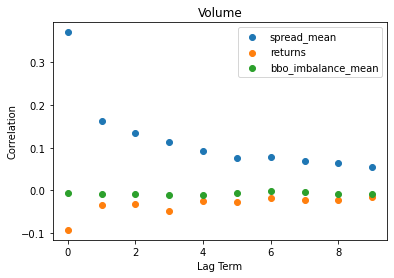

In [65]:
terms=10
for i,j in enumerate(features):
    if j!='Volume':
        plt.scatter([x for x in range (0,terms)],corr[j][:terms],label=str(j))
        plt.xlabel('Lag Term')
        plt.ylabel("Correlation")
        plt.title("Volume")
        plt.legend()

In [66]:
corr={}
for j in features:
    if j!='spread_mean':
        vs=df_data[['spread_mean',j]].dropna()
        crosscorr=ccf(vs['spread_mean'],vs[j])
        corr[j]=crosscorr

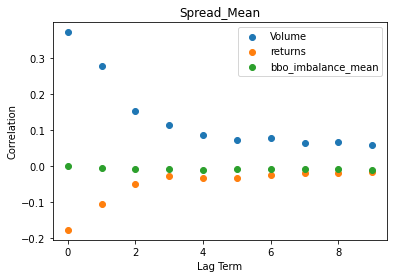

In [67]:
terms=10
for i,j in enumerate(features):
    if j!='spread_mean':
        plt.scatter([x for x in range (0,terms)],corr[j][:terms],label=str(j))
        plt.xlabel('Lag Term')
        plt.ylabel("Correlation")
        plt.title("Spread_Mean")
        plt.legend()

In [68]:
corr={}
for j in features:
    if j!='returns':
        vs=df_data[['returns',j]].dropna()
        crosscorr=ccf(vs['returns'],vs[j])
        corr[j]=crosscorr

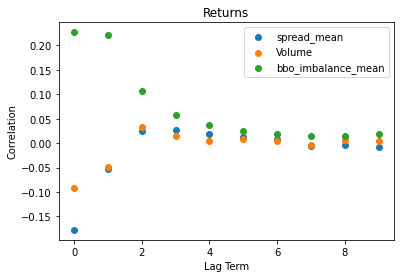

In [69]:
terms=10
for i,j in enumerate(features):
    if j!='returns':
        plt.scatter([x for x in range (0,terms)],corr[j][:terms],label=str(j))
        plt.xlabel('Lag Term')
        plt.ylabel("Correlation")
        plt.title("Returns")
        plt.legend()

### Granger Causality
https://en.wikipedia.org/wiki/Granger_causality

In [89]:
from statsmodels.tsa.stattools import grangercausalitytests
import math

### P-Value Quantifying the Effect of Returns on each TS

In [151]:
granger=dict(zip(features,[[] for i in features]))
for i in range (0,math.floor(df_data.shape[0]/300)-1):
    for counter,j in enumerate(features):
        if j!='returns':
            vs=df_data[[j,'returns']][300*i:300*(i+1)].dropna()
            if vs.shape[0]<60:
                continue
            
            try:
                granger[j].append(list(grangercausalitytests(vs,[1],verbose=False).values())[0][0]['ssr_chi2test'][1])
            except:
                pass
            
     

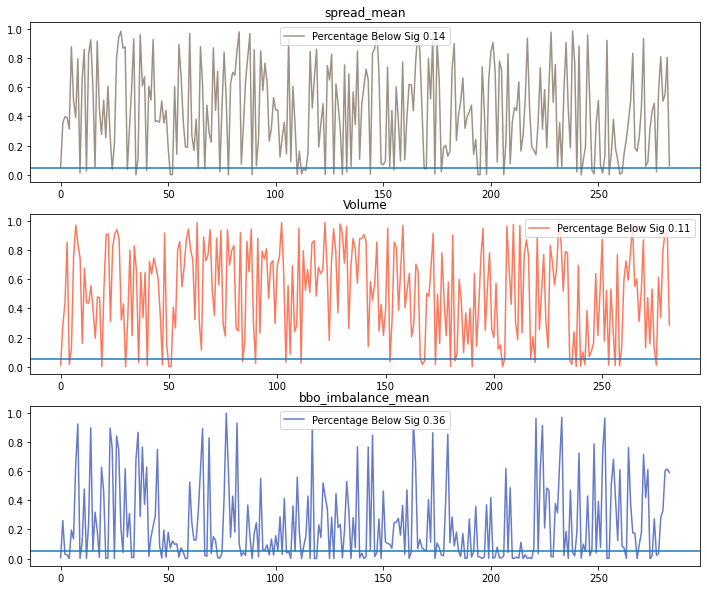

In [154]:
fig,ax=plt.subplots(3,1,figsize=(12,10))
counter=0
for key,val in granger.items():
    if len(val)==0:
        continue
    sig=len(np.array(val)[np.array(val)<0.05])/len(val)
    ax[counter].plot(val,label=f"Percentage Below Sig {round(sig,2)}", c=np.random.rand(3))
    ax[counter].axhline(0.05)
    ax[counter].set_title(key)
    ax[counter].legend()
    
    counter+=1

### P-Value Quantifying the Effect of Spread_Mean on each TS

In [155]:
granger=dict(zip(features,[[] for i in features]))
for i in range (0,math.floor(df_data.shape[0]/300)-1):
    for counter,j in enumerate(features):
        if j!='spread_mean':
            vs=df_data[[j,'spread_mean']][300*i:300*(i+1)].dropna()
            if vs.shape[0]<60:
                continue
            
            try:
                granger[j].append(list(grangercausalitytests(vs,[1],verbose=False).values())[0][0]['ssr_chi2test'][1])
            except:
                pass
            
     

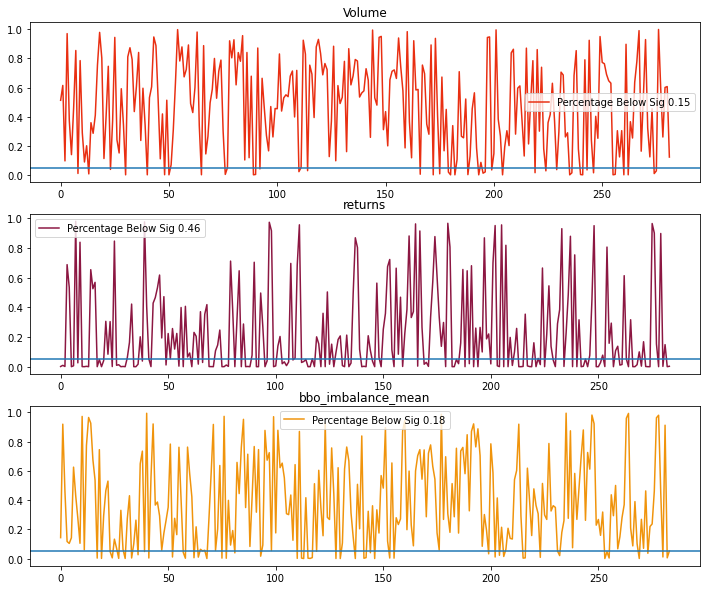

In [157]:
fig,ax=plt.subplots(3,1,figsize=(12,10))
counter=0
for key,val in granger.items():
    if len(val)==0:
        continue
    sig=len(np.array(val)[np.array(val)<0.05])/len(val)
    ax[counter].plot(val,label=f"Percentage Below Sig {round(sig,2)}", c=np.random.rand(3))
    ax[counter].axhline(0.05)
    ax[counter].set_title(key)
    ax[counter].legend()
    
    counter+=1

### P-Value Quantifying the Effect of Volume on each TS

In [158]:
granger=dict(zip(features,[[] for i in features]))
for i in range (0,math.floor(df_data.shape[0]/300)-1):
    for counter,j in enumerate(features):
        if j!='Volume':
            vs=df_data[[j,'Volume']][300*i:300*(i+1)].dropna()
            if vs.shape[0]<60:
                continue
            
            try:
                granger[j].append(list(grangercausalitytests(vs,[1],verbose=False).values())[0][0]['ssr_chi2test'][1])
            except:
                pass
            

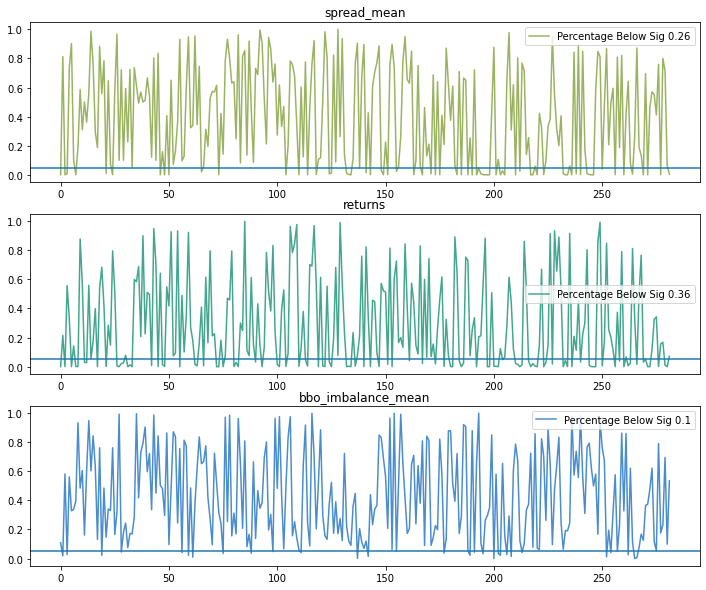

In [159]:
fig,ax=plt.subplots(3,1,figsize=(12,10))
counter=0
for key,val in granger.items():
    if len(val)==0:
        continue
    sig=len(np.array(val)[np.array(val)<0.05])/len(val)
    ax[counter].plot(val,label=f"Percentage Below Sig {round(sig,2)}", c=np.random.rand(3))
    ax[counter].axhline(0.05)
    ax[counter].set_title(key)
    ax[counter].legend()
    
    counter+=1

### P-Value Quantifying the Effect of BBO_Imbalance on each TS

In [160]:
granger=dict(zip(features,[[] for i in features]))
for i in range (0,math.floor(df_data.shape[0]/300)-1):
    for counter,j in enumerate(features):
        if j!='bbo_imbalance_mean':
            vs=df_data[[j,'bbo_imbalance_mean']][300*i:300*(i+1)].dropna()
            if vs.shape[0]<60:
                continue
            
            try:
                granger[j].append(list(grangercausalitytests(vs,[1],verbose=False).values())[0][0]['ssr_chi2test'][1])
            except:
                pass
            

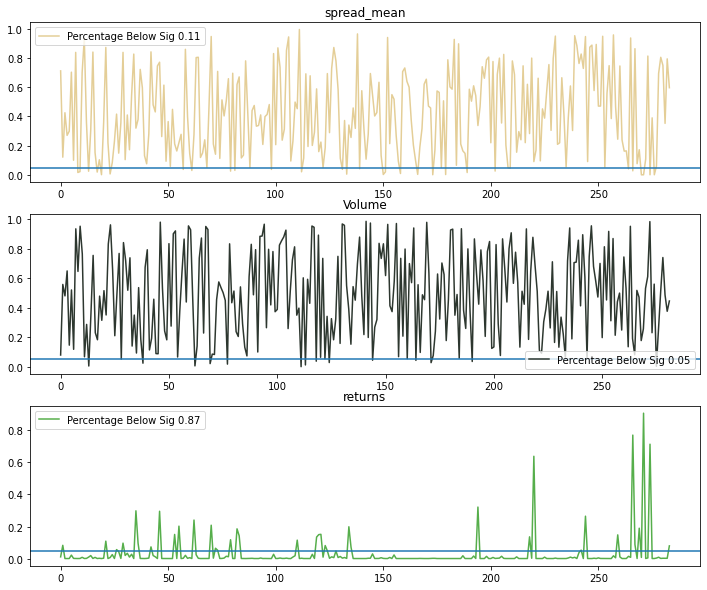

In [161]:
fig,ax=plt.subplots(3,1,figsize=(12,10))
counter=0
for key,val in granger.items():
    if len(val)==0:
        continue
    sig=len(np.array(val)[np.array(val)<0.05])/len(val)
    ax[counter].plot(val,label=f"Percentage Below Sig {round(sig,2)}", c=np.random.rand(3))
    ax[counter].axhline(0.05)
    ax[counter].set_title(key)
    ax[counter].legend()
    
    counter+=1